In [1]:
from custom_class import CustomCrossValidator
from tools import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE, VarianceThreshold

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Import the split data set
target_df = pd.read_csv("data/target_columns.csv")
independent_df = pd.read_csv("data/independent_columns.csv")

In [3]:
# Joining the data sets
wells_df = pd.merge(target_df, independent_df, on='id', how='inner')

In [4]:
# Standardize categorical variables
wells_df = wells_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [5]:
# Convert boolean values to strings
wells_df = wells_df.applymap(lambda x: str(x) if isinstance(x, bool) else x)

In [6]:
# Standardize missing values to NaN
missing_values = ['', ' ', 'na', 'n/a', 'unknown', 'other', 'none']
wells_df.replace(missing_values, np.nan, inplace=True)

In [7]:
# Set 'id' as the index of the DataFrame
wells_df.set_index('id', inplace=True)

In [8]:
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55759 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55741 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               55832 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15

## Target Variable Investigation

In [9]:
wells_df['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

There is a class imbalance between the three classes inside of the target variable. We will need to handle this through by either oversampling or SMOTE'ing to bring the minority class in proportion with the majority class.

Given the small proportion of the 'function needs repair' class we will combine the 'functional needs repair' and 'non functional' class together to create the new class 'needs attention'. Then we will cast the 'functional' class of wells as 'does not need attention'. 

In [10]:
# Define the mapping of the new labels
label_mapping = {
    'functional': 0,
    'non functional': 1,
    'functional needs repair': 1
}

# Replace the values in the 'status_group' column
wells_df['status_group'] = wells_df['status_group'].replace(label_mapping)

In [11]:
wells_df['status_group'].value_counts(normalize=True)

0    0.543081
1    0.456919
Name: status_group, dtype: float64

# Data Cleaning

## Amount TSH: Illogical Values

In [12]:
filtered_df = wells_df[wells_df['amount_tsh'] >= 50000]

filtered_df['amount_tsh'].value_counts()

117000.0    7
50000.0     4
100000.0    3
250000.0    1
138000.0    1
70000.0     1
350000.0    1
60000.0     1
170000.0    1
200000.0    1
120000.0    1
Name: amount_tsh, dtype: int64

Most total static head measurements are in the range of hundreds to tens of thousands.

Depths exceeding 50,000 units (e.g., feet or meters) are rare or unusual so we will filter these out as they are outliers. 

Most residential wells range from a few meters to around 100 meters (10 to 300 feet).

Wells used for industrial or agricultural purposes may have deeper total static heads, often ranging from tens to several hundred meters (hundreds to thousands of feet). 

In [13]:
wells_df = wells_df[wells_df['amount_tsh'] <= 50000]

## Longitude and Latitude: Zero Value Coordinates

In [14]:
wells_df['longitude'].value_counts()

0.000000     1812
37.252194       2
37.297680       2
33.010510       2
39.093484       2
             ... 
36.871976       1
37.579803       1
33.196490       1
34.017119       1
30.163579       1
Name: longitude, Length: 57498, dtype: int64

In [15]:
wells_df['latitude'].value_counts()

-2.000000e-08    1812
-7.104923e+00       2
-6.964258e+00       2
-6.963565e+00       2
-7.056372e+00       2
                 ... 
-3.411358e+00       1
-8.958207e+00       1
-3.261113e+00       1
-5.435762e+00       1
-2.598965e+00       1
Name: latitude, Length: 57499, dtype: int64

In [16]:
# Filtering to see if any other rows are affected
filtered_df = wells_df[wells_df['longitude'] == 0]

print(len(filtered_df))

filtered_df.head()

1812


,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
6091,0,0.0,2013-02-10,dwsp,0,dwe,0.0,-2.000000e-08,muungano,0,...,NaN,NaN,NaN,NaN,NaN,shallow well,shallow well,groundwater,hand pump,hand pump
32376,1,0.0,2011-08-01,government of tanzania,0,government,0.0,-2.000000e-08,polisi,0,...,NaN,NaN,NaN,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
72678,0,0.0,2013-01-30,wvt,0,wvt,0.0,-2.000000e-08,wvt tanzania,0,...,NaN,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
56725,1,0.0,2013-01-17,netherlands,0,dwe,0.0,-2.000000e-08,kikundi cha wakina mama,0,...,NaN,soft,good,enough,enough,shallow well,shallow well,groundwater,NaN,NaN
13042,1,0.0,2012-10-29,hesawa,0,dwe,0.0,-2.000000e-08,kwakisusi,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


Since these wells have longitude and latiude of 0 it is safe to say that these wells while they were recorded either have an unknown location or do not have a location inside of Tanzania and as such are not reliable data point.

We will be dropping all of these rows from the dataset.

In [17]:
wells_df = wells_df[wells_df['longitude'] != 0]

## Installer Column: Typos

In [18]:
wells_df['installer'].nunique()

1903

In [19]:
installer_replacement_dict = {
    'central government': 'central government',
    'tanzania government': 'central government',
    'cental government': 'central government',
    'cebtral government': 'central government',
    'centra government': 'central government',
    'central govt': 'central government',
    'centr': 'central government',
    'centra govt': 'central government',
    'tanzanian government': 'central government',
    'tanzania': 'central government',
    
    'district council': 'district council',
    'counc': 'district council',
    'district counci': 'district council',
    'council': 'district council',
    'coun': 'district council',
    'distri': 'district council',
    'district  council': 'district council',
    
    'villigers': 'villagers',
    'villager': 'villagers',
    'villa': 'villagers',
    'village': 'villagers',
    'villi': 'villagers',
    'village council': 'villagers',
    'village counil': 'villagers',
    'villages': 'villagers',
    'vill': 'villagers',
    'village community': 'villagers',
    'villaers': 'villagers',
    'villag': 'villagers',
    'villege council': 'villagers',
    'villagerd': 'villagers',
    'village technician': 'villagers',
    'village office': 'villagers',
    'village community members': 'villagers',
    'village government': 'villagers',
    'village govt': 'villagers',
    
    'district water department': 'district water department',
    'district water depar': 'district water department',
    'distric water department': 'district water department',
    
    'finw': 'fini water',
    'fini water': 'fini water',
    'fin water': 'fini water',
    'finwater': 'fini water',
    'finn water': 'fini water',
    'fw': 'fini water',
    
    'rc church': 'rc church',
    'rc churc': 'rc church',
    'rc': 'rc church',
    'rc ch': 'rc church',
    'rc c': 'rc church',
    'rc cathoric': 'rc church',
    'ch': 'rc church',
    
    'world vision': 'world vision',
    'world division': 'world vision',
    'world vission': 'world vision',
    
    'unisef': 'unicef',
    'unicef': 'unicef',
    
    'danid': 'danida',
    
    'commu': 'community',
    'communit': 'community',
    'adra /community': 'community',
    'adra/community': 'community',
    'adra/ community': 'community',
    
    'government': 'government',
    'gover': 'government',
    'governme': 'government',
    'goverm': 'government',
    'govern': 'government',
    'gove': 'government',
    'governmen': 'government',
    
    'hesawa': 'hesawa',
    
    'jaica': 'jaica',
    'jica': 'jaica',
    'jeica': 'jaica',
    'jaica co': 'jaica',
    
    'kkkt _ konde and dwe': 'kkkt',
    'kkt': 'kkkt',
    'kkkt church': 'kkkt'
}

In [20]:
wells_df['installer'] = wells_df['installer'].replace(installer_replacement_dict)

In [21]:
wells_df['installer'].nunique()

1835

## Formatting Cleanup

In [22]:
# Function to replace "other - " prefix
def replace_other_prefix(value):
    if isinstance(value, str) and value.startswith('other -'):
        return value.split('other -', 1)[1].strip()
    return value

# Apply the function to the entire DataFrame
wells_df = wells_df.applymap(replace_other_prefix)

## Missing Values

### Categorical columns with 0's

In [23]:
# Replace all 0's with NaNs
for col in wells_df.columns:
    if wells_df[col].dtype == 'O':
        wells_df[col] = wells_df[col].replace('0', np.nan)

## Applying the correct data types

The columns listed below act more as lables than as integers. They identify a specific aspect of about the row entry and as such should be considered categorical variables.

In [24]:
wells_df['region_code'] = wells_df['region_code'].astype(str)
wells_df['district_code'] = wells_df['district_code'].astype(str)

## Missing values

In [25]:
# Assuming you already have 'expected_length' and 'wells_df' defined
expected_length = 59400
columns_with_missing_values = {}

# Iterate over columns to find those not meeting expected length
for col in wells_df.columns:
    if wells_df[col].count() != expected_length:
        columns_with_missing_values[col] = {
            'missing_count': expected_length - wells_df[col].count(),
            'unique_count': len(wells_df[col].value_counts()),
            'dtype': wells_df[col].dtype  # Add data type information
        }

# Print the dictionary
for col, info in columns_with_missing_values.items():
    print(f"{col}': Missing Values: {info['missing_count']}, Unique Values: {info['unique_count']}, Dtype: {info['dtype']}")

status_group': Missing Values: 1830, Unique Values: 2, Dtype: int64
amount_tsh': Missing Values: 1830, Unique Values: 88, Dtype: float64
date_recorded': Missing Values: 1830, Unique Values: 353, Dtype: object
funder': Missing Values: 6234, Unique Values: 1854, Dtype: object
gps_height': Missing Values: 1830, Unique Values: 2428, Dtype: int64
installer': Missing Values: 6246, Unique Values: 1834, Dtype: object
longitude': Missing Values: 1830, Unique Values: 57497, Dtype: float64
latitude': Missing Values: 1830, Unique Values: 57498, Dtype: float64
wpt_name': Missing Values: 5327, Unique Values: 36707, Dtype: object
num_private': Missing Values: 1830, Unique Values: 65, Dtype: int64
basin': Missing Values: 1830, Unique Values: 9, Dtype: object
subvillage': Missing Values: 2201, Unique Values: 18566, Dtype: object
region': Missing Values: 1830, Unique Values: 21, Dtype: object
region_code': Missing Values: 1830, Unique Values: 27, Dtype: object
district_code': Missing Values: 1830, Uniqu

### Filling Missing Values

Since all of the columns above are categorical columns, we will be filling them with the string 'unknown' so that we can maintain as much data as possible. 

In [26]:
wells_df.fillna('unknown', inplace=True)

In [27]:
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57570 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           57570 non-null  int64  
 1   amount_tsh             57570 non-null  float64
 2   date_recorded          57570 non-null  object 
 3   funder                 57570 non-null  object 
 4   gps_height             57570 non-null  int64  
 5   installer              57570 non-null  object 
 6   longitude              57570 non-null  float64
 7   latitude               57570 non-null  float64
 8   wpt_name               57570 non-null  object 
 9   num_private            57570 non-null  int64  
 10  basin                  57570 non-null  object 
 11  subvillage             57570 non-null  object 
 12  region                 57570 non-null  object 
 13  region_code            57570 non-null  object 
 14  district_code          57570 non-null  object 
 15

## Dropping Columns

In [28]:
are_identical = wells_df['quantity'].equals(wells_df['quantity_group'])
print('Are they identical?', are_identical)

Are they identical? True


We are going to drop the following columns:

- 'recorded_by'
    - All records were recorded by the same person. No unique data is provided.
- 'quantity_group'
    - This column is identical to 'quantity'
- 'date_recorded'
    - The date that the information was recorded does not hold valuable information for determining the status of the well. 
- 'num_private'
    - There is no description for this column inside of the data table's documentation. 
    - https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/

In [29]:
# Drop columns
wells_df.drop(['recorded_by', 'quantity_group', 'date_recorded', 'num_private'], axis=1, inplace=True)

# Baseline Feature Importance

## Baseline Feature Importance: Decision Tree

In [30]:
baseline_dt_df = wells_df.copy()

In [31]:
# Encode categorical variables using LabelEncoder
le = LabelEncoder()
for col in baseline_dt_df.select_dtypes(include='object').columns:
    baseline_dt_df[col] = le.fit_transform(baseline_dt_df[col])

In [32]:
X_train, X_test, y_train, y_test = split_data(baseline_dt_df, 'status_group')

In [33]:
# Train a simple decision tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [34]:
# Get feature importances
importances = dt.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

In [35]:
# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
29,quantity,0.143414
4,longitude,0.109715
5,latitude,0.095917
34,waterpoint_type_group,0.074964
6,wpt_name,0.072433
8,subvillage,0.063031
2,gps_height,0.047830
19,construction_year,0.038912
13,ward,0.037973
14,population,0.035885


## Baseline Feature Importance: RFE

In [36]:
# Initialize RFE 
rfe = RFE(estimator=dt, n_features_to_select=10)

In [37]:
# Fit RFE
rfe.fit(X_train, y_train)

RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=10)

In [38]:
# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['funder', 'gps_height', 'longitude', 'latitude', 'wpt_name',
       'subvillage', 'ward', 'construction_year', 'quantity',
       'waterpoint_type'],
      dtype='object')


In [39]:
# Get feature ranking
ranking = rfe.ranking_
feature_ranking = pd.DataFrame({'Feature': X_train.columns, 'Ranking': ranking})

# Sort by ranking
feature_ranking = feature_ranking.sort_values(by='Ranking')
print("Features ranked by importance:")
print(feature_ranking)

Features ranked by importance:
                  Feature  Ranking
1                  funder        1
2              gps_height        1
4               longitude        1
5                latitude        1
6                wpt_name        1
29               quantity        1
8              subvillage        1
19      construction_year        1
13                   ward        1
33        waterpoint_type        1
14             population        2
12                    lga        3
0              amount_tsh        4
3               installer        5
22  extraction_type_class        6
9                  region        7
17            scheme_name        8
23             management        9
30                 source       10
25                payment       11
20        extraction_type       12
16      scheme_management       13
18                 permit       14
28          quality_group       15
11          district_code       16
7                   basin       17
21  extraction_type_grou

## Baseline Feature Importance: Analysis

In [40]:
# Merge feature importance and ranking DataFrames on feature names
baseline_feature_analysis_df = pd.merge(
feature_importance_df, feature_ranking, on='Feature', suffixes=('_importance', '_ranking')
)

Now that we have combined the feature selections together we can filter the dataframe so we can see the featuresthat are less likely to contribute to our models performance.

We will want to look at any feature that matches both of the criteria listed below and consider dropping those features. 

For RFE (Recursive Feature Elimination) features with higher ranks are considered less important by RFE so we will look at features with a rank below 20. 

For the decision tree feature importance, we will look at features that have a gini impurity below .01. 

In [41]:
# Filter the DataFrame
features_to_drop = baseline_feature_analysis_df[
    (baseline_feature_analysis_df['Importance'] < 0.01) & 
    (baseline_feature_analysis_df['Ranking'] >= 20)
]['Feature']

In [42]:
features_to_drop

29         region_code
30        payment_type
31       water_quality
32    management_group
33      public_meeting
34        source_class
Name: Feature, dtype: object

In [43]:
columns_to_drop = {}

for col in features_to_drop:
    columns_to_drop[col] = {
        'dtype' : wells_df[col].dtype,
        'unique_values' : wells_df[col].nunique()
    }
    
columns_to_drop

{'region_code': {'dtype': dtype('O'), 'unique_values': 27},
 'payment_type': {'dtype': dtype('O'), 'unique_values': 6},
 'water_quality': {'dtype': dtype('O'), 'unique_values': 8},
 'management_group': {'dtype': dtype('O'), 'unique_values': 4},
 'public_meeting': {'dtype': dtype('O'), 'unique_values': 3},
 'source_class': {'dtype': dtype('O'), 'unique_values': 3}}

### 'source_class' and 'source_type'

In [44]:
wells_df['source_class'].value_counts()

groundwater    44201
surface        13103
unknown          266
Name: source_class, dtype: int64

In [45]:
wells_df['source_type'].value_counts()

spring                  17006
shallow well            15498
borehole                11697
river/lake              10236
rainwater harvesting     2218
dam                       649
unknown                   266
Name: source_type, dtype: int64

Even though this a low scoring column, the water source of the well is most likely a good indicator of the status of the well itself. We will want to retain as much information as we can that can lead us to determining the functional status of a well.

### 'payment_type'

In [46]:
wells_df['payment_type'].value_counts()

never pay     24380
per bucket     8953
unknown        8556
monthly        8216
on failure     3841
annually       3624
Name: payment_type, dtype: int64

In [47]:
wells_df['payment'].value_counts()

never pay                24380
pay per bucket            8953
unknown                   8556
pay monthly               8216
pay when scheme fails     3841
pay annually              3624
Name: payment, dtype: int64

This column is essentially the same as 'payment' as such we can drop this column.

### 'public_meeting'

In [48]:
wells_df['public_meeting'].value_counts()

True       49722
False       4872
unknown     2976
Name: public_meeting, dtype: int64

Given its low scores and that there is no further information given in the documentation aside from True/False, we will drop this column.

### 'management_group'

In [49]:
wells_df['management_group'].value_counts()

user-group    50755
commercial     3634
parastatal     1691
unknown        1490
Name: management_group, dtype: int64

- How the waterpoint is managed?

This could indicate how different management practices that affect the functionality of the well. As such, we will want to keep this column.

### 'water_quality'

In [50]:
wells_df['water_quality'].value_counts()

soft                  49413
salty                  4772
unknown                1661
milky                   803
coloured                479
salty abandoned         228
fluoride                199
fluoride abandoned       15
Name: water_quality, dtype: int64

In [51]:
wells_df['quality_group'].value_counts()

good        49413
salty        5000
unknown      1661
milky         803
colored       479
fluoride      214
Name: quality_group, dtype: int64

While there is less crossover inside of water_quality and quality_group we will want to keep both. 

The water quality of the well is most likely one of the best indicators of the status of the well. 

We will want to retain as much information as we can that can lead us to determining the functional status of a well.

### Dropping columns

In [52]:
wells_df = wells_df.drop(['payment_type', 'public_meeting'], axis=1)

## Columns with too many unique values

In [53]:
wells_df.nunique()

status_group                 2
amount_tsh                  88
funder                    1855
gps_height                2428
installer                 1835
longitude                57497
latitude                 57498
wpt_name                 36708
basin                        9
subvillage               18567
region                      21
region_code                 27
district_code               20
lga                        124
ward                      2033
population                1047
scheme_management           11
scheme_name               2537
permit                       3
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  11
management_group             4
payment                      6
water_quality                8
quality_group                6
quantity                     5
source                       9
source_type                  7
source_class                 3
waterpoi

Given the high amount of unique values that exist inside of various columns, we will bucket the values that fall under 1% of the columns total values. 

We will only be bucketing values for columns that have over 30 unique values so that we  maintain all of the unique values in columns that have smaller amount of unique values. 

In [54]:
too_many_unique_columns = []

for col in wells_df.columns:
    if wells_df[col].dtype == 'object' and wells_df[col].nunique() > 30:
        too_many_unique_columns.append(col)
        
too_many_unique_columns

['funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name']

In [55]:
for col in too_many_unique_columns:
    if wells_df[col].dtype == 'object': 
        freq = wells_df[col].value_counts(normalize=True)
        mask = wells_df[col].isin(freq[freq >= 0.01].index)
        wells_df.loc[~mask, col] = 'other'

In [56]:
wells_df.nunique()

status_group                 2
amount_tsh                  88
funder                      19
gps_height                2428
installer                   15
longitude                57497
latitude                 57498
wpt_name                     4
basin                        9
subvillage                   1
region                      21
region_code                 27
district_code               20
lga                         35
ward                         1
population                1047
scheme_management           11
scheme_name                  3
permit                       3
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  11
management_group             4
payment                      6
water_quality                8
quality_group                6
quantity                     5
source                       9
source_type                  7
source_class                 3
waterpoi

# Column Correlation

## Numeric Columns

In [57]:
correlation_matrix = wells_df.corr()

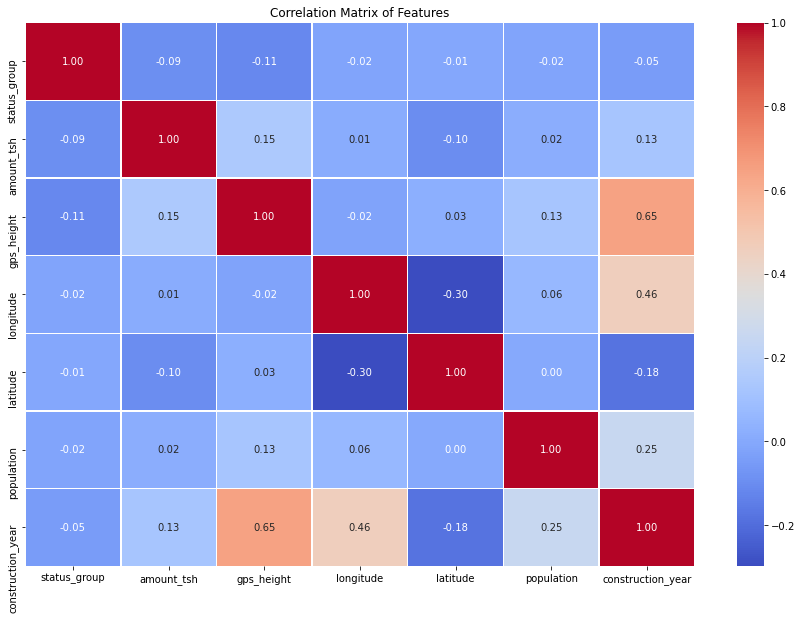

In [58]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

# Add title and labels
plt.title('Correlation Matrix of Features')
plt.show()

While some columns border on being too correlated with each other (~0.80), none of columns exceed this threshold. If a column had multiple high correlations (either positive or negative) with other columns we would drop that column, but this is not the case. 

# Scoring Metric

Inside of all the models listed below, we are using recall as our scoring metric. 

In the target variable, we started with three classes:
- Functional
- Non-Functional
- Functional needs repair

We combined the non-functional and the functional needs repair classes due to the heavy class imbalance inside of the functional needs repair class. Since functional needs repair and non-functional wells could both be classified into a needs attention class we combined them. Our updated classes are:

- Does not need attention (for functional wells)
- Needs attention (for non-functional and functionally needs repair wells)

As such, here is a breakdown of our confusion matrix:
- True Positive (TP): Correctly predicting a well as "Does not need attention".
- False Positive (FP): Incorrectly predicting a well as "Needs attention" when it actually does not need attention.
- True Negative (TN): Correctly predicting a well as "Needs attention".
- False Negative (FN): Incorrectly predicting a well as "Does not need attention" when it actually needs attention.

We chose to use recall as our primary scoring metric because it measures the proportion of wells that need attention that are correctly predicted as being in need of attention.

# Base Logistic Regression Models

In [59]:
base_log_model_df = wells_df.copy()

In [60]:
X_train, X_test, y_train, y_test = split_data(base_log_model_df, 'status_group')

In [61]:
base_logistic_model = LogisticRegression(random_state=42, max_iter=2000)

In [62]:
base_log_cv = CustomCrossValidator(base_logistic_model, X_train, y_train)

In [63]:
sampling_methods = ['oversample', 'undersample', 'smote']

In [64]:
base_log_cv.run_sampling_methods(sampling_methods, features=None, features_from='base', folds=5)

Running cross-validation with sampling method: oversample

Running cross-validation with sampling method: undersample

Running cross-validation with sampling method: smote

Log: {('LogisticRegression', 'base', 'oversample'): 0.7043794944655426, ('LogisticRegression', 'base', 'undersample'): 0.7032904517477562, ('LogisticRegression', 'base', 'smote'): 0.7011659423295937}


# Base Decision Tree Models

In [65]:
base_dt_model_df = wells_df.copy()

In [66]:
X_train, X_test, y_train, y_test = split_data(base_dt_model_df, 'status_group')

In [67]:
base_dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=20, min_samples_leaf=10)

In [68]:
base_dt_cv = CustomCrossValidator(base_dt_model, X_train, y_train)

In [69]:
base_dt_cv.run_sampling_methods(sampling_methods, features=None, features_from='base', folds=5)

Running cross-validation with sampling method: oversample

Running cross-validation with sampling method: undersample

Running cross-validation with sampling method: smote

Log: {('LogisticRegression', 'base', 'oversample'): 0.7043794944655426, ('LogisticRegression', 'base', 'undersample'): 0.7032904517477562, ('LogisticRegression', 'base', 'smote'): 0.7011659423295937, ('DecisionTreeClassifier', 'base', 'oversample'): 0.5150329468026201, ('DecisionTreeClassifier', 'base', 'undersample'): 0.5310489564026828, ('DecisionTreeClassifier', 'base', 'smote'): 0.5393838624465799}


# Lasso Regression: Feature Selection

In [70]:
lasso_regression_df = wells_df.copy()

## Feature Selection

In [71]:
# Set X, y variables and split

X_train, X_test, y_train, y_test = split_data(lasso_regression_df, 'status_group')

In [72]:
X_train_numeric_scaled_df, X_test_numeric_scaled_df = scale_numeric_features(X_train, X_test)

In [73]:
encoded_train_df, encoded_test_df = encode_categorical_features(X_train, X_test)

In [74]:
# Combine scaled and encoded features
X_train_preprocessed = combine_features(X_train_numeric_scaled_df, encoded_train_df)

X_test_preprocessed = combine_features(X_test_numeric_scaled_df, encoded_test_df)

In [75]:
# Define a range of alpha values to test
alpha_range = np.logspace(-5, 0, 10)

# Initialize an empty list to store the mean cross-validated scores
cv_scores = []

In [76]:
# Perform cross-validation for each alpha
for alpha in alpha_range:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=4000)
    scores = cross_val_score(lasso, X_train_preprocessed, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(np.mean(scores))

# Find the best alpha (the one with the highest score)
best_alpha = alpha_range[np.argmax(cv_scores)]

print(f"Best alpha: {best_alpha}")

Best alpha: 3.5938136638046256e-05


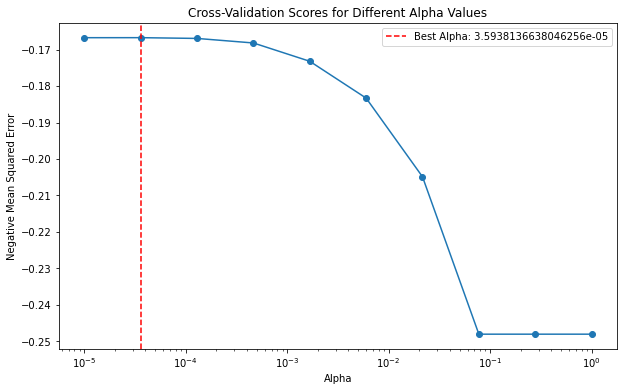

In [77]:
# Plot the mean cross-validated scores as a function of the alpha values
plt.figure(figsize=(10, 6))
plt.plot(alpha_range, cv_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Negative Mean Squared Error')
plt.title('Cross-Validation Scores for Different Alpha Values')
plt.axvline(x=best_alpha, color='red', linestyle='--', label=f'Best Alpha: {best_alpha}')
plt.legend()
plt.show()

In [78]:
# Fit the Lasso model
lasso = Lasso(alpha=best_alpha, random_state=42, max_iter=2000)
lasso.fit(X_train_preprocessed, y_train)

Lasso(alpha=3.5938136638046256e-05, max_iter=2000, random_state=42)

In [79]:
# Get the coefficients from the Lasso model
coef = lasso.coef_

In [80]:
lasso_selected_features = X_train_preprocessed.columns[coef != 0]
print(f"Starting Features: {X_train_preprocessed.shape[1]}")
print()
print(f"Selected Features: {len(lasso_selected_features)}")

Starting Features: 284

Selected Features: 222


Lasso Regression set the coefficient of 62 features to 0 indicating that these features are not considered important for predicting the target variable.

## Lasso Features: Logistic Regression

In [81]:
lasso_logistic_model_df = wells_df.copy()

X_train, X_test, y_train, y_test = split_data(lasso_logistic_model_df, 'status_group')

In [82]:
lasso_logistic_model = LogisticRegression(random_state=42, max_iter=2000)

In [83]:
lasso_logistic_cv = CustomCrossValidator(
    model=lasso_logistic_model,
    X=X_train,
    y=y_train,
)

In [84]:
lasso_logistic_cv.run_sampling_methods(
    sampling_methods, 
    features=lasso_selected_features, 
    folds=5,
    features_from='LassoRegression'
)

Running cross-validation with sampling method: oversample

Running cross-validation with sampling method: undersample

Running cross-validation with sampling method: smote

Log: {('LogisticRegression', 'base', 'oversample'): 0.7043794944655426, ('LogisticRegression', 'base', 'undersample'): 0.7032904517477562, ('LogisticRegression', 'base', 'smote'): 0.7011659423295937, ('DecisionTreeClassifier', 'base', 'oversample'): 0.5150329468026201, ('DecisionTreeClassifier', 'base', 'undersample'): 0.5310489564026828, ('DecisionTreeClassifier', 'base', 'smote'): 0.5393838624465799, ('LogisticRegression', 'LassoRegression', 'oversample'): 0.7042706510250216, ('LogisticRegression', 'LassoRegression', 'undersample'): 0.703290555606001, ('LogisticRegression', 'LassoRegression', 'smote'): 0.7020921204826858}


## Lasso Features: Decision Tree

In [85]:
lasso_dt_model_df = wells_df.copy()

X_train, X_test, y_train, y_test = split_data(lasso_dt_model_df, 'status_group')

In [86]:
lasso_dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=20, min_samples_leaf=10)

In [87]:
lasso_dt_cv = CustomCrossValidator(
    model=lasso_dt_model,
    X=X_train,
    y=y_train,
)

In [88]:
lasso_dt_cv.run_sampling_methods(
    sampling_methods, 
    features=lasso_selected_features, 
    folds=5,
    features_from='LassoRegression'
)

Running cross-validation with sampling method: oversample

Running cross-validation with sampling method: undersample

Running cross-validation with sampling method: smote

Log: {('LogisticRegression', 'base', 'oversample'): 0.7043794944655426, ('LogisticRegression', 'base', 'undersample'): 0.7032904517477562, ('LogisticRegression', 'base', 'smote'): 0.7011659423295937, ('DecisionTreeClassifier', 'base', 'oversample'): 0.5150329468026201, ('DecisionTreeClassifier', 'base', 'undersample'): 0.5310489564026828, ('DecisionTreeClassifier', 'base', 'smote'): 0.5393838624465799, ('LogisticRegression', 'LassoRegression', 'oversample'): 0.7042706510250216, ('LogisticRegression', 'LassoRegression', 'undersample'): 0.703290555606001, ('LogisticRegression', 'LassoRegression', 'smote'): 0.7020921204826858, ('DecisionTreeClassifier', 'LassoRegression', 'oversample'): 0.5163946025760406, ('DecisionTreeClassifier', 'LassoRegression', 'undersample'): 0.534045563502195, ('DecisionTreeClassifier', 'Lasso

# VIF: Feature Selection

In [89]:
vif_df = wells_df.copy()

## Feature Selection

In [90]:
# Split the data
X_train, X_test, y_train, y_test = split_data(vif_df, target='status_group')

# Scale numeric features
X_train_numeric_scaled, X_test_numeric_scaled = scale_numeric_features(X_train, X_test)

# Encode categorical features
X_train_encoded, X_test_encoded = encode_categorical_features(X_train, X_test)

# Combine numeric and categorical features
X_train_preprocessed = combine_features(X_train_numeric_scaled, X_train_encoded)
X_test_preprocessed = combine_features(X_test_numeric_scaled, X_test_encoded)

In [91]:
# Remove features with variance below 1%
selector = VarianceThreshold(threshold=0.01)
X_train_reduced_df = selector.fit_transform(X_train_preprocessed)

# Get the selected feature names
selected_features = X_train_preprocessed.columns[selector.get_support()]

# Create a new DataFrame with selected features
X_train_reduced_df = pd.DataFrame(X_train_reduced_df, columns=selected_features)

In [92]:
X_train_reduced_df.shape

(40299, 234)

In [93]:
# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Apply VIF calculation on reduced DataFrame
vif_data_reduced = calculate_vif(X_train_reduced_df)

vif_data_reduced

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                                      feature        VIF
0                                  amount_tsh   1.326252
1                                  gps_height  11.058491
2                                   longitude  90.910726
3                                    latitude  94.372529
4                                  population   1.224808
..                                        ...        ...
229                   waterpoint_type_unknown        inf
230  waterpoint_type_group_communal standpipe        inf
231           waterpoint_type_group_hand pump        inf
232     waterpoint_type_group_improved spring        inf
233             waterpoint_type_group_unknown        inf

[234 rows x 2 columns]


In [94]:
vif_under_10 = vif_data_reduced[vif_data_reduced['VIF'] < 10]

In [95]:
vif_selected_features = list(vif_under_10['feature'])

len(vif_selected_features)

43

## VIF Features: Logistic Regression

In [96]:
vif_logistic_model_df = wells_df.copy()

X_train, X_test, y_train, y_test = split_data(vif_logistic_model_df, 'status_group')

In [97]:
vif_logistic_model = LogisticRegression(random_state=42, max_iter=2000)

In [98]:
vif_logistic_cv = CustomCrossValidator(
    model=vif_logistic_model,
    X=X_train,
    y=y_train,
)

In [99]:
vif_logistic_cv.run_sampling_methods(
    sampling_methods, 
    features=vif_selected_features, 
    folds=5,
    features_from='VIF'
)

Running cross-validation with sampling method: oversample

Running cross-validation with sampling method: undersample

Running cross-validation with sampling method: smote

Log: {('LogisticRegression', 'base', 'oversample'): 0.7043794944655426, ('LogisticRegression', 'base', 'undersample'): 0.7032904517477562, ('LogisticRegression', 'base', 'smote'): 0.7011659423295937, ('DecisionTreeClassifier', 'base', 'oversample'): 0.5150329468026201, ('DecisionTreeClassifier', 'base', 'undersample'): 0.5310489564026828, ('DecisionTreeClassifier', 'base', 'smote'): 0.5393838624465799, ('LogisticRegression', 'LassoRegression', 'oversample'): 0.7042706510250216, ('LogisticRegression', 'LassoRegression', 'undersample'): 0.703290555606001, ('LogisticRegression', 'LassoRegression', 'smote'): 0.7020921204826858, ('DecisionTreeClassifier', 'LassoRegression', 'oversample'): 0.5163946025760406, ('DecisionTreeClassifier', 'LassoRegression', 'undersample'): 0.534045563502195, ('DecisionTreeClassifier', 'Lasso

## VIF Features: Decision Tree

In [100]:
vif_dt_model_df = wells_df.copy()

X_train, X_test, y_train, y_test = split_data(vif_dt_model_df, 'status_group')

In [101]:
vif_dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=20, min_samples_leaf=10)

In [102]:
vif_dt_cv = CustomCrossValidator(
    model=vif_dt_model,
    X=X_train,
    y=y_train,
)

In [103]:
vif_dt_cv.run_sampling_methods(
    sampling_methods, 
    features=vif_selected_features, 
    folds=5,
    features_from='VIF'
)

Running cross-validation with sampling method: oversample

Running cross-validation with sampling method: undersample

Running cross-validation with sampling method: smote

Log: {('LogisticRegression', 'base', 'oversample'): 0.7043794944655426, ('LogisticRegression', 'base', 'undersample'): 0.7032904517477562, ('LogisticRegression', 'base', 'smote'): 0.7011659423295937, ('DecisionTreeClassifier', 'base', 'oversample'): 0.5150329468026201, ('DecisionTreeClassifier', 'base', 'undersample'): 0.5310489564026828, ('DecisionTreeClassifier', 'base', 'smote'): 0.5393838624465799, ('LogisticRegression', 'LassoRegression', 'oversample'): 0.7042706510250216, ('LogisticRegression', 'LassoRegression', 'undersample'): 0.703290555606001, ('LogisticRegression', 'LassoRegression', 'smote'): 0.7020921204826858, ('DecisionTreeClassifier', 'LassoRegression', 'oversample'): 0.5163946025760406, ('DecisionTreeClassifier', 'LassoRegression', 'undersample'): 0.534045563502195, ('DecisionTreeClassifier', 'Lasso

# Current Model Results

In [106]:
def get_log_results_df():
    # Extracting the log dictionary
    log_dict = vif_dt_cv.log
    
    # Initialize an empty list to store the rows
    log_list = []
    
    # Iterate over the log dictionary and append each entry as a tuple to the list
    for key, value in log_dict.items():
        model, feature_selection, sampling = key
        score = value
        log_list.append((model, feature_selection, sampling, score))
    
    # Convert the list to a DataFrame
    log_df = pd.DataFrame(log_list, columns=['Model', 'Feature Selection', 'Sampling Technique', 'Recall-Score'])
    
    return log_df

In [135]:
log_df = get_log_results_df()
log_df.sort_values(by='Recall-Score', ascending=False)

,Model,Feature Selection,Sampling Technique,Recall-Score
15,DecisionTreeClassifier,VIF,oversample,0.770180
17,DecisionTreeClassifier,VIF,smote,0.768383
16,DecisionTreeClassifier,VIF,undersample,0.767511
0,LogisticRegression,base,oversample,0.704379
6,LogisticRegression,LassoRegression,oversample,0.704271
7,LogisticRegression,LassoRegression,undersample,0.703291
1,LogisticRegression,base,undersample,0.703290
18,LogisticRegression,dimensionality_reduction,oversample,0.703072
8,LogisticRegression,LassoRegression,smote,0.702092
19,LogisticRegression,dimensionality_reduction,undersample,0.701656


So far, the best model is the base model with undersampling to account for the class imbalance. 

We were hoping that either the VIF or Lasso feature selection would result in a better model but it has not. 

It is worth noting that the base decision tree given that there is no max depth set the model is most likley overfitting. 

However, we would like to perform dimensionality reduction on like-columns to determine if we can get better scores. 

# Dimensionality Reduction

Various columns contain similar information. While these columns are not a equal in every regard, they are similar enough as to where our models may perform better if we removed these features. We had originally kept these features as we thought having the extra data points inside of these features would be helpful for classification. 

If the columns contain over 80% of shared row values, we will drop a column. 

We will be comparing the following features:

- 'scheme_management' and 'management'
- 'region' and 'region_code'
- 'extraction_type' and 'extraction_type_group'
- 'water_quality' and 'quality_group'
- 'source' and 'source_type'
- 'waterpoint_type' and 'waterpoint_type_group'

In [108]:
def get_shared_values_percentage(df, pairs):
    """
    Calculates the percentage of shared values between pairs of columns in a DataFrame. 
    
    Return a dictionary with the shared values percentage.
    ---
    Input:
    df: Pandas DataFrame
    pairs : A list of tuples
    ---
    Output:
    dict: A dictionary 
    """
    result = {}
    
    for column1, column2 in pairs:
        # Create a new DataFrame with only the two specified columns
        df_subset = df[[column1, column2]].copy()
        
        # Create a new column that indicates if the values in the two columns are the same
        df_subset['is_same'] = df_subset[column1] == df_subset[column2]
    
        # Count the number of shared values (where the values are the same in both columns)
        shared_values_count = df_subset['is_same'].sum()
    
        # Calculate the percentage of shared values
        shared_values_percentage = (shared_values_count / len(df_subset)) * 100
        
        # Store the result in the dictionary
        result[(column1, column2)] = shared_values_percentage
    
    return result

In [109]:
# Define the list of column pairs to compare
pairs = [
    ('scheme_management', 'management'),
    ('extraction_type', 'extraction_type_group'),
    ('water_quality', 'quality_group'),
    ('source', 'source_type'),
    ('waterpoint_type', 'waterpoint_type_group')
]

In [110]:
# Calculate shared values percentages for each pair
results = get_shared_values_percentage(wells_df, pairs)
results

{('scheme_management', 'management'): 83.8909154073302,
 ('extraction_type', 'extraction_type_group'): 96.64929650859823,
 ('water_quality', 'quality_group'): 12.914712523883967,
 ('source', 'source_type'): 61.902032308494,
 ('waterpoint_type', 'waterpoint_type_group'): 89.65085982282439}

Given the results above, we will take a closer look at the following pairs:

- 'scheme_management' and 'management'
- 'extraction_type' and 'extraction_type_group'
- 'waterpoint_type' and 'waterpoint_type_group'

We will also take a look at 'region' and 'region_code' seperately as while the values are not the same, they contain similar information. 

## 'scheme_management' and 'management'

In [111]:
wells_df['scheme_management'].value_counts()

vwc                 36140
unknown              4516
wug                  4248
water authority      3150
wua                  2872
water board          2747
parastatal           1605
private operator     1063
company              1060
swc                    97
trust                  72
Name: scheme_management, dtype: int64

In [112]:
wells_df['management'].value_counts()

vwc                 39743
wug                  5554
water board          2932
wua                  2526
private operator     1969
parastatal           1691
unknown              1391
water authority       902
company               685
school                 99
trust                  78
Name: management, dtype: int64

Since management has fewer unknown values, we will drop the 'scheme_management' column from the DataFrame. 

## 'extraction_type' and 'extraction_type_group'

In [113]:
wells_df['extraction_type'].value_counts()

gravity              26687
nira/tanira           7361
unknown               6160
submersible           4687
swn 80                3447
mono                  2815
india mark ii         2283
afridev               1659
ksb                   1354
rope pump              451
swn 81                 229
windmill               117
india mark iii          91
cemo                    90
play pump               85
climax                  32
walimi                  20
mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [114]:
wells_df['extraction_type_group'].value_counts()

gravity            26687
nira/tanira         7361
unknown             6160
submersible         6041
swn 80              3447
mono                2815
india mark ii       2283
afridev             1659
rope pump            451
other handpump       336
other motorpump      122
wind-powered         117
india mark iii        91
Name: extraction_type_group, dtype: int64

Since the 'extration_type' column is more specific than 'extraction_type_group', we will be dropping 'extraction_type_group' from the DataFrame. 

## 'waterpoint_type' and 'waterpoint_type_group'

In [115]:
wells_df['waterpoint_type'].value_counts()

communal standpipe             28360
hand pump                      16179
unknown                         6167
communal standpipe multiple     5958
improved spring                  783
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [116]:
wells_df['waterpoint_type_group'].value_counts()

communal standpipe    34318
hand pump             16179
unknown                6167
improved spring         783
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

Since the 'waterpoint_type' column is more specific than 'waterpoint_type_group', we will be dropping 'waterpoint_type_group' from the DataFrame. 

## 'region' and 'region_code'

In [117]:
len(wells_df['region'].value_counts())

21

In [118]:
len(wells_df['region_code'].value_counts())

27

Since the 'region_code' contains more values than the region, we will be dropping 'region' from the DataFrame.

## Dropping columns

In [119]:
dimensionality_reduction_df = wells_df.copy()

In [120]:
dimensionality_reduction_df.drop(['scheme_management','extraction_type_group', 'waterpoint_type_group', 'region'], axis=1, inplace=True)

In [121]:
dimensionality_reduction_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57570 entries, 69572 to 26348
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           57570 non-null  int64  
 1   amount_tsh             57570 non-null  float64
 2   funder                 57570 non-null  object 
 3   gps_height             57570 non-null  int64  
 4   installer              57570 non-null  object 
 5   longitude              57570 non-null  float64
 6   latitude               57570 non-null  float64
 7   wpt_name               57570 non-null  object 
 8   basin                  57570 non-null  object 
 9   subvillage             57570 non-null  object 
 10  region_code            57570 non-null  object 
 11  district_code          57570 non-null  object 
 12  lga                    57570 non-null  object 
 13  ward                   57570 non-null  object 
 14  population             57570 non-null  int64  
 15

# Dimensionality Reduction: Logistic Model

In [122]:
dim_reduct_logistic_model_df = dimensionality_reduction_df.copy()

In [123]:
X_train, X_test, y_train, y_test = split_data(dim_reduct_logistic_model_df, 'status_group')

In [124]:
dim_reduct_logistic_model = LogisticRegression(random_state=42, max_iter=2000)

In [125]:
dim_reduct_log_cv = CustomCrossValidator(dim_reduct_logistic_model, X_train, y_train)

In [126]:
dim_reduct_log_cv.run_sampling_methods(sampling_methods, features=None, features_from='dimensionality_reduction', folds=5)

Running cross-validation with sampling method: oversample

Running cross-validation with sampling method: undersample

Running cross-validation with sampling method: smote

Log: {('LogisticRegression', 'base', 'oversample'): 0.7043794944655426, ('LogisticRegression', 'base', 'undersample'): 0.7032904517477562, ('LogisticRegression', 'base', 'smote'): 0.7011659423295937, ('DecisionTreeClassifier', 'base', 'oversample'): 0.5150329468026201, ('DecisionTreeClassifier', 'base', 'undersample'): 0.5310489564026828, ('DecisionTreeClassifier', 'base', 'smote'): 0.5393838624465799, ('LogisticRegression', 'LassoRegression', 'oversample'): 0.7042706510250216, ('LogisticRegression', 'LassoRegression', 'undersample'): 0.703290555606001, ('LogisticRegression', 'LassoRegression', 'smote'): 0.7020921204826858, ('DecisionTreeClassifier', 'LassoRegression', 'oversample'): 0.5163946025760406, ('DecisionTreeClassifier', 'LassoRegression', 'undersample'): 0.534045563502195, ('DecisionTreeClassifier', 'Lasso

# Dimensionality Reduction: Decision Tree 

In [127]:
dim_reduct_dt_model_df = dimensionality_reduction_df.copy()

In [128]:
X_train, X_test, y_train, y_test = split_data(dim_reduct_dt_model_df, 'status_group')

In [129]:
dim_reduct_dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=20, min_samples_leaf=10)

In [130]:
dim_reduct_dt_cv = CustomCrossValidator(dim_reduct_dt_model, X_train, y_train)

In [131]:
dim_reduct_dt_cv.run_sampling_methods(sampling_methods, features=None, features_from='dimensionality_reduction', folds=5)

Running cross-validation with sampling method: oversample

Running cross-validation with sampling method: undersample

Running cross-validation with sampling method: smote

Log: {('LogisticRegression', 'base', 'oversample'): 0.7043794944655426, ('LogisticRegression', 'base', 'undersample'): 0.7032904517477562, ('LogisticRegression', 'base', 'smote'): 0.7011659423295937, ('DecisionTreeClassifier', 'base', 'oversample'): 0.5150329468026201, ('DecisionTreeClassifier', 'base', 'undersample'): 0.5310489564026828, ('DecisionTreeClassifier', 'base', 'smote'): 0.5393838624465799, ('LogisticRegression', 'LassoRegression', 'oversample'): 0.7042706510250216, ('LogisticRegression', 'LassoRegression', 'undersample'): 0.703290555606001, ('LogisticRegression', 'LassoRegression', 'smote'): 0.7020921204826858, ('DecisionTreeClassifier', 'LassoRegression', 'oversample'): 0.5163946025760406, ('DecisionTreeClassifier', 'LassoRegression', 'undersample'): 0.534045563502195, ('DecisionTreeClassifier', 'Lasso

# Review Model Results

In [134]:
log_df = get_log_results_df()
log_df.sort_values(by='Recall-Score', ascending=False)

,Model,Feature Selection,Sampling Technique,Recall-Score
15,DecisionTreeClassifier,VIF,oversample,0.770180
17,DecisionTreeClassifier,VIF,smote,0.768383
16,DecisionTreeClassifier,VIF,undersample,0.767511
0,LogisticRegression,base,oversample,0.704379
6,LogisticRegression,LassoRegression,oversample,0.704271
7,LogisticRegression,LassoRegression,undersample,0.703291
1,LogisticRegression,base,undersample,0.703290
18,LogisticRegression,dimensionality_reduction,oversample,0.703072
8,LogisticRegression,LassoRegression,smote,0.702092
19,LogisticRegression,dimensionality_reduction,undersample,0.701656


Since we have two different models, we will hyper-parameter tune the best two types of models to determine which is the best classifier. 

We will hyper-parameter tune the following models to determine which model performs best on the validation fold. 
- DecisionTree - VIF - Oversampling
- LogisiticRegression - base - Oversampling

Once determined, we will run the best model on the test data. 